# Usage demonstration of Scipy's `LowLevelCallable` in conjunction with Cython

We show how to speed up the calculation of this exemplary integral with multiple paramters

$$
I(a, b) = \int_0^\infty \mathrm{d}x\, \frac{x \mathrm{e}^{-ax}}{\tanh x} \cos(bx)
$$

by means of Cython in combination with Scipy's `quad` routine.

## Create extension module `.pyx`

In [1]:
%%writefile module.pyx

from libc.math cimport exp, tanh, cos

cdef double c_integrand(double x):
    if x == 0:
        return 1
    else:
        return x * exp(-x)/tanh(x) * cos(10 * x)  

cpdef double cp_integrand(double x):
    if x == 0:
        return 1
    else:
        return x * exp(-x)/tanh(x) * cos(10 * x)
    
import math
def integrand(x):
    if x == 0:
        return 1
    else:
        return x * math.exp(-x)/math.tanh(x) * math.cos(10 * x) 

Writing module.pyx


## Create a corresponding `.pxd` declaration file

In [2]:
%%writefile module.pxd

cdef double c_integrand(double x)
cpdef double cp_integrand(double x)

Writing module.pxd


In [3]:
import pyximport; pyximport.install(inplace=True, language_level=3)

(None, <pyximport.pyximport.PyxImporter at 0x7fbc787be2b0>)

In [4]:
import module
module?

Type:        module
String form: <module 'module' (/home/daniel/Privat/CythonPrivate/module.cpython-36m-x86_64-linux-gnu.so)>
File:        ~/Privat/CythonPrivate/module.cpython-36m-x86_64-linux-gnu.so
Docstring:   <no docstring>


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0, 10, 200)
y = [module.integrand(x_i) for x_i in x]

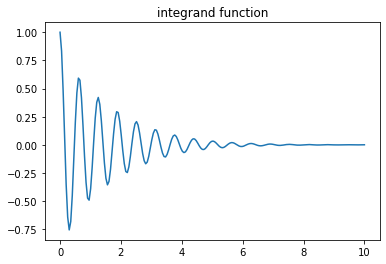

In [6]:
plt.plot(x, y); plt.title("integrand function");

In [7]:
from scipy.integrate import quad
from scipy import LowLevelCallable

from module import cp_integrand
from module import integrand
import math

# along to the compiled module, a corresponding .pxd file with declarations is necessary
ll_cython_c_integrand = LowLevelCallable.from_cython(module, 'c_integrand')
ll_cython_cp_integrand = LowLevelCallable.from_cython(module, 'cp_integrand')

# integration limits
a, b = 0, math.inf

def integral1():
    return quad(integrand, a, b)

def integral2():
    return quad(cp_integrand, a, b)

def integral3():
    return quad(ll_cython_c_integrand, a, b)

def integral4():
    return quad(ll_cython_cp_integrand, a, b)

## Timing results

In [8]:
# pure Python version
%timeit integral1()

538 µs ± 11.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
# Cython version of integrand, passed over to quad as PyObject
%timeit integral2()

237 µs ± 6.84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [10]:
# Cython version of integrand, passed over to quad as LowLevelCallable
%timeit integral3()

157 µs ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [11]:
# LowLevelCallable does not accept cpdef declared functions
try:
    integral4()
except Exception as e:
    print(e)

Invalid scipy.LowLevelCallable signature "double (double, int __pyx_skip_dispatch)". Expected one of: ['double (double, void *)', 'double (int, double *, void *)', 'double (double)', 'double (int, double *)']


## Putting Integration routine inside Cython extension module

In [12]:
%%writefile module_inplace.pxd

cdef double c_integrand(double x)

Writing module_inplace.pxd


In [13]:
%%writefile module_inplace.pyx

# refer to module inside the module itself
import sys
current_module = sys.modules[__name__]

from scipy.integrate import quad
from scipy import LowLevelCallable

from libc.math cimport exp, tanh, cos

cdef double c_integrand(double x):
    if x == 0:
        return 1
    else:
        return x * exp(-x)/tanh(x) * cos(10 * x)  

ll_cython_c_integrand_inside_module = LowLevelCallable.from_cython(current_module, 'c_integrand')

import math
def integral5():
    return quad(ll_cython_c_integrand_inside_module, 0, math.inf)

Writing module_inplace.pyx


In [14]:
import pyximport; pyximport.install(inplace=True, language_level=3)

(None, None)

In [15]:
from module_inplace import integral5

In [16]:
%timeit integral5()

142 µs ± 1.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
# final check
np.allclose(integral1(), integral2(), integral3(), integral5())

True

In [18]:
!rm module*